# Deep Q Network (DQN) for Super Mario Bros


## Imports


In [1]:
import collections
import os
import tempfile
import time
import warnings

import gym
import gym_super_mario_bros
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT, SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace
from torch.optim import Adam
from tqdm import tqdm

from setup import create_directories
from src.DQN import DQN
from src.ExperienceBuffer import ExperienceReplayBuffer
from src.utils import plot_results, preprocess_frame, preprocess_state

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device(
#     "mps"
#     if torch.backends.mps.is_available() and torch.backends.mps.is_built()
#     else "cpu"
# )

np.random.seed(42)
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
warnings.simplefilter("ignore")
print(device)

cuda


## Environment


In [2]:
ENV_NAME = "SuperMarioBros-1-1-v0"
env = gym_super_mario_bros.make(ENV_NAME)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [3]:
print("Observation Space: ", env.observation_space.shape)
print("Action Space: ", env.action_space.n)
print(SIMPLE_MOVEMENT)

Observation Space:  (240, 256, 3)
Action Space:  7
[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]


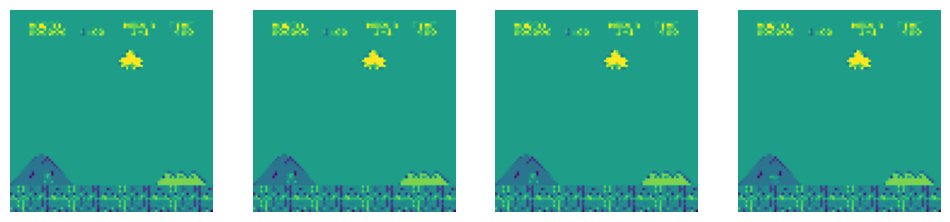

In [4]:
state = env.reset()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes = axes.flatten()
for i in range(4):
    state, reward, done, info = env.step(env.action_space.sample())
    state = preprocess_frame(state)

    axes[i].imshow(state)
    axes[i].axis("off")

## Train Agent


### Set Parameter


In [2]:
train_version = None
agent = "dqn"
create_directories(agent)

model_folder = (
    os.path.join("models", agent)
    if train_version == None
    else os.path.join("models", f"{agent}_v{train_version}")
)
checkpoint_folder = os.path.join(model_folder, "checkpoints")

videos_folder = (
    os.path.join("references", agent, "videos")
    if train_version == None
    else os.path.join("references", f"{agent}_v{train_version}", "videos")
)
plot_folder = (
    os.path.join("references", agent, "images")
    if train_version == None
    else os.path.join("references", f"{agent}_v{train_version}", "images")
)
evaluation_folder = (
    os.path.join("references", agent, "evaluation")
    if train_version == None
    else os.path.join("references", f"{agent}_v{train_version}", "evaluation")
)


# set path for checkpoint to load from
starting_point = None  # os.path.join(checkpoint_folder, "model_ep850.pth")

In [3]:
ENV_NAME = "SuperMarioBros-1-1-v0"
GAMMA = 0.99
N_EPISODES = 1000
EPSILON_START = 1.0
EPSILON_END = 0.1
# uncomment the following line to use exponential decay
# EPSILON_DECAY = 0.995
# uncomment the following line to use linear decay
EPSILON_DECAY = (EPSILON_START - EPSILON_END) / N_EPISODES

LEARNING_RATE = 1e-4
REPLAY_BUFFER = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 10
CHECKPOINT_RATE = 100
N_STACKD_FRAMES = 4
INPUT_SHAPE = (4, 84, 84)

### Create Instances


In [7]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

dqn = DQN(INPUT_SHAPE, env.action_space.n).to(device)
target_net = DQN(INPUT_SHAPE, env.action_space.n).to(device)
target_net.load_state_dict(dqn.state_dict())
target_net.eval()

optimizer = Adam(dqn.parameters(), lr=LEARNING_RATE)
replay_buffer = ExperienceReplayBuffer(REPLAY_BUFFER)

### Train Agent


Training: 100%|██████████| 1000/1000 [15:45:50<00:00, 56.75s/it]  


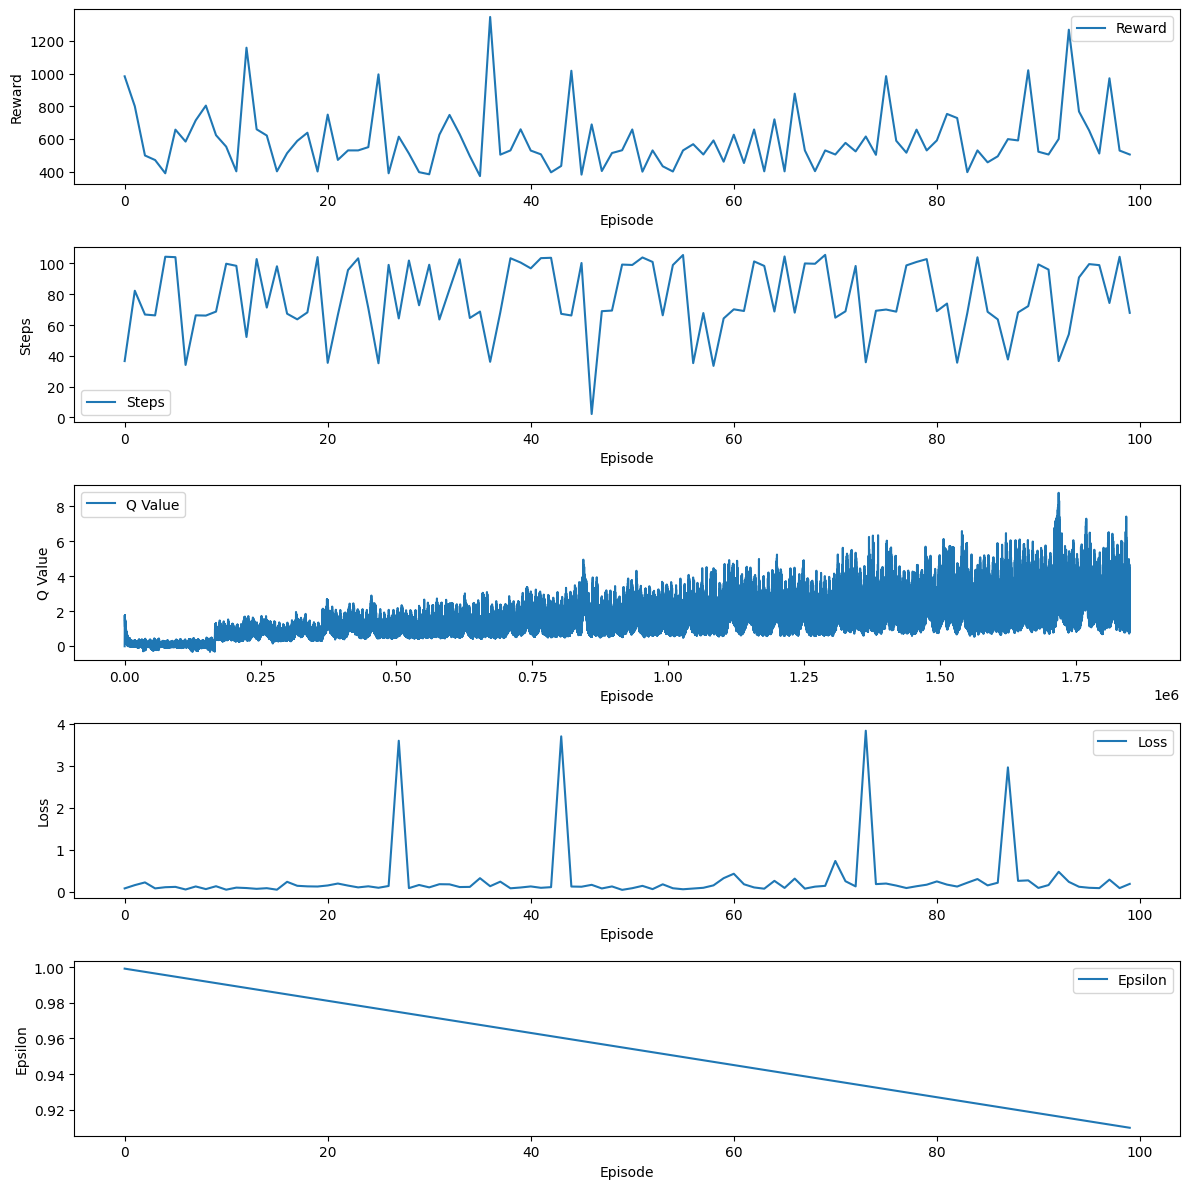

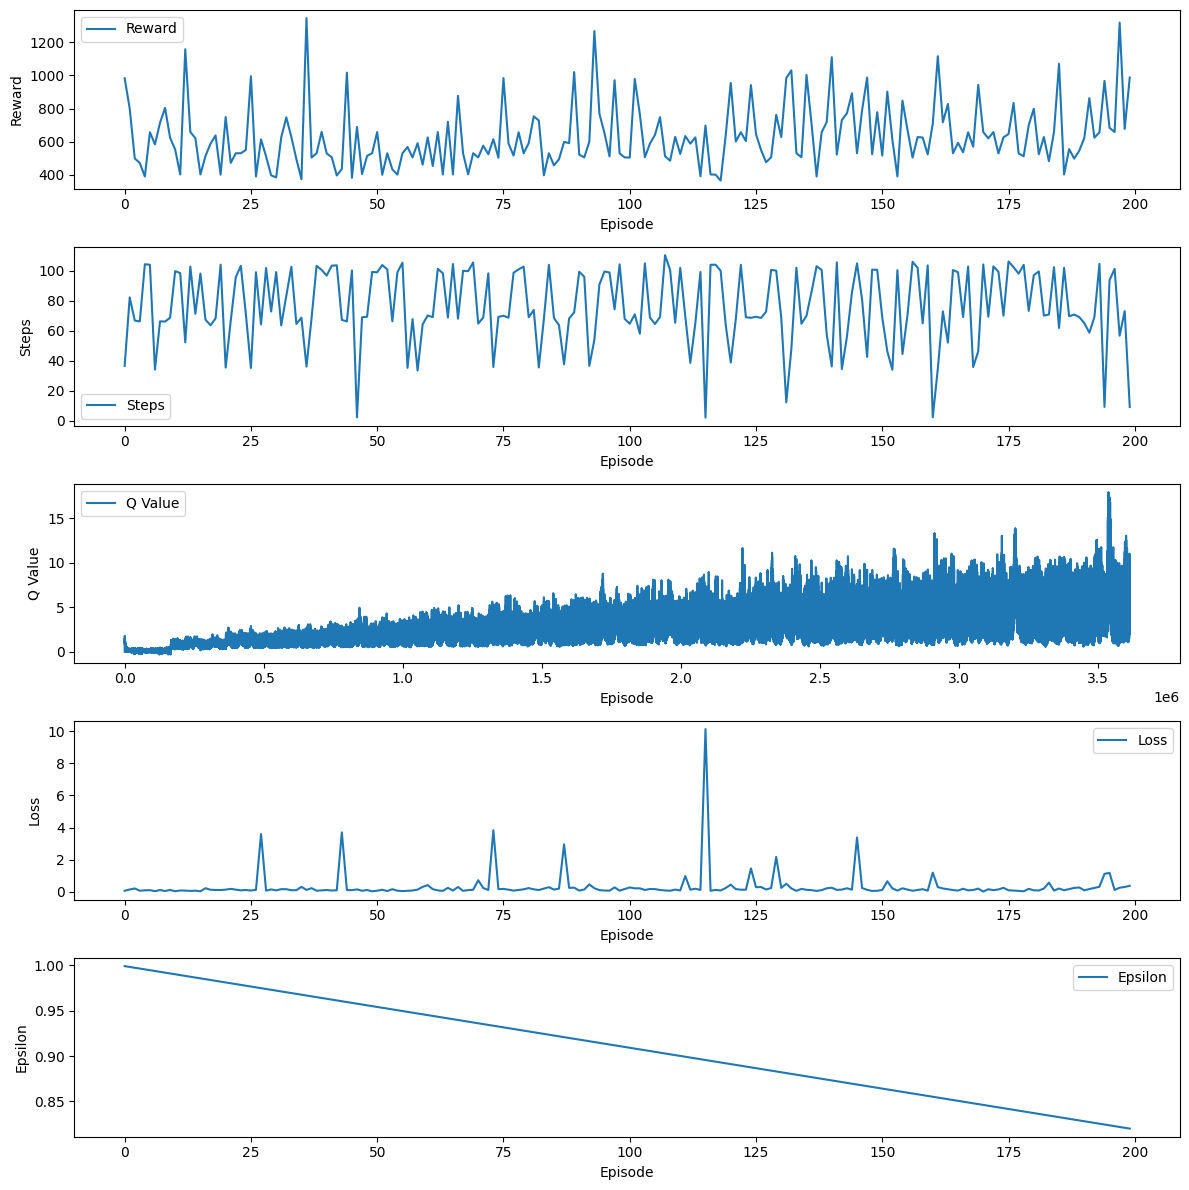

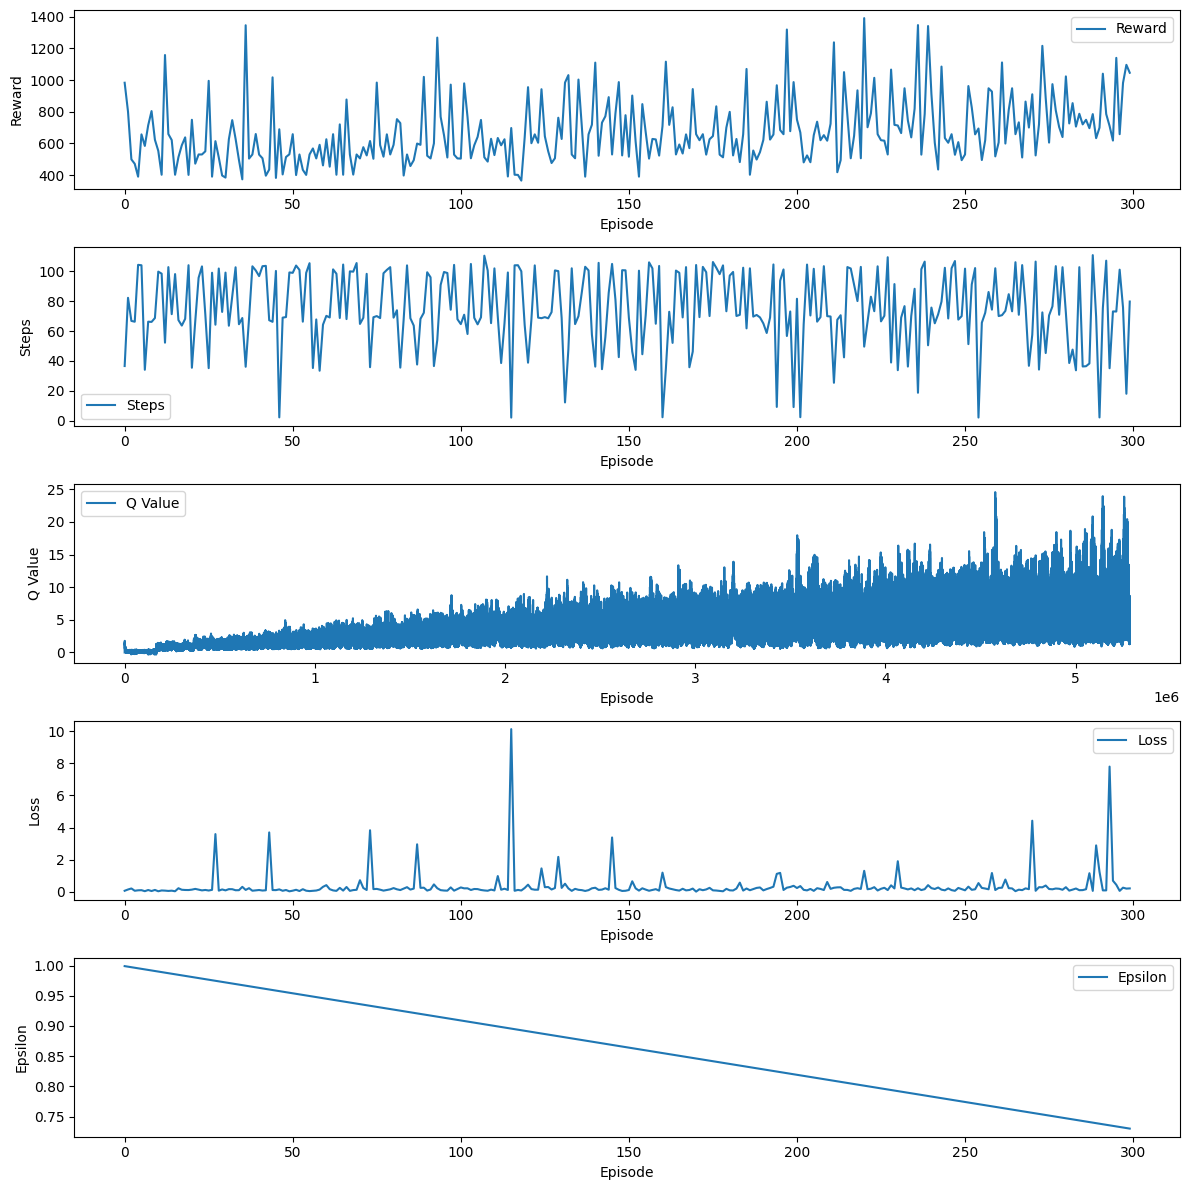

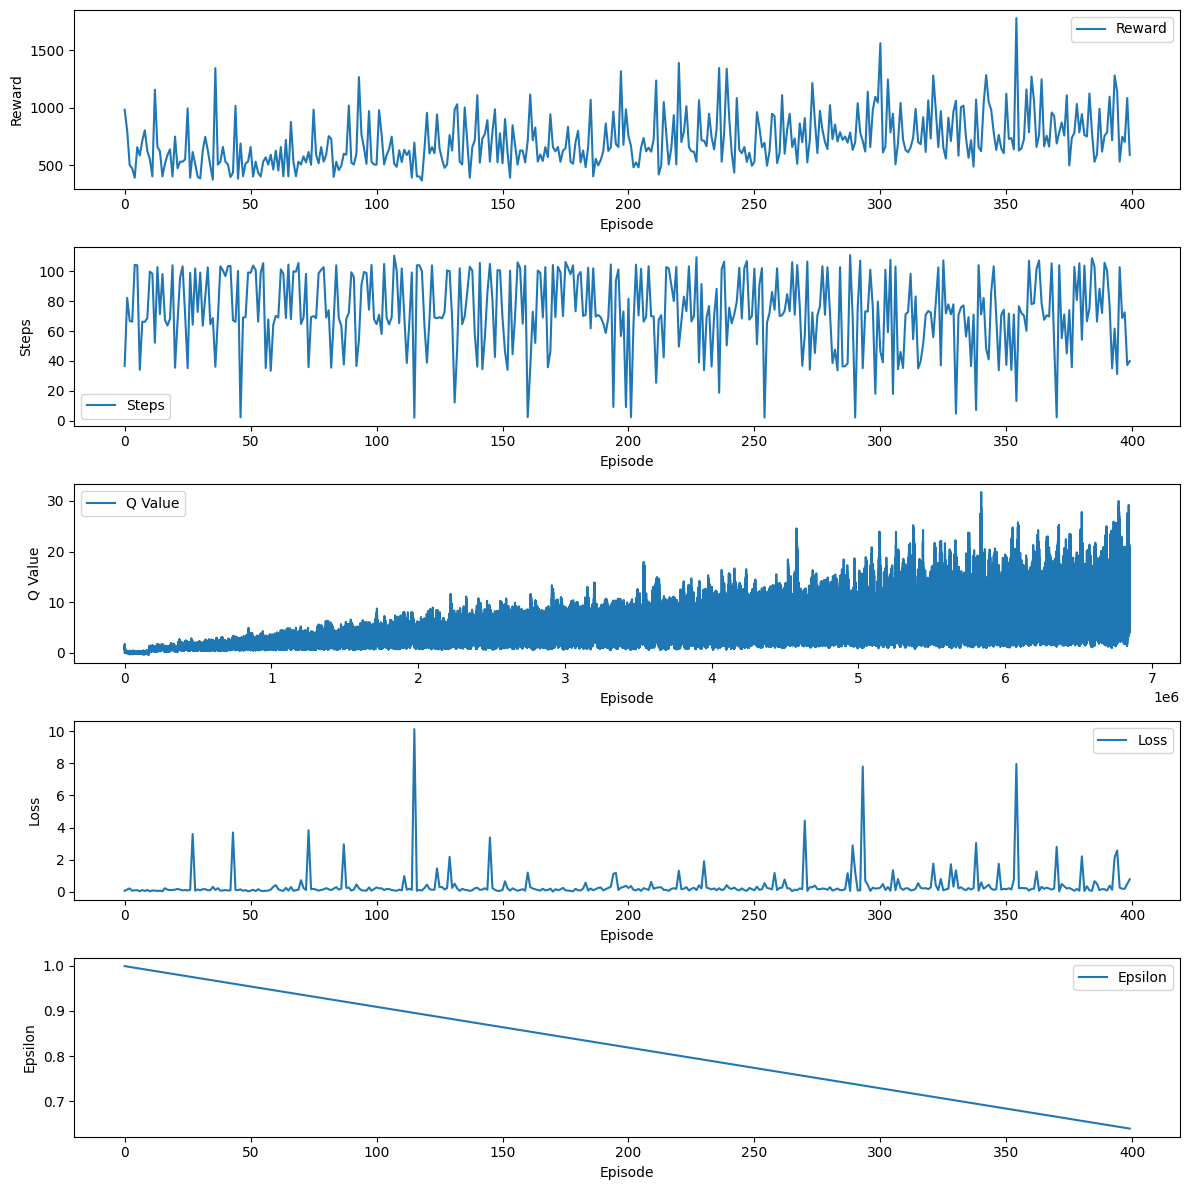

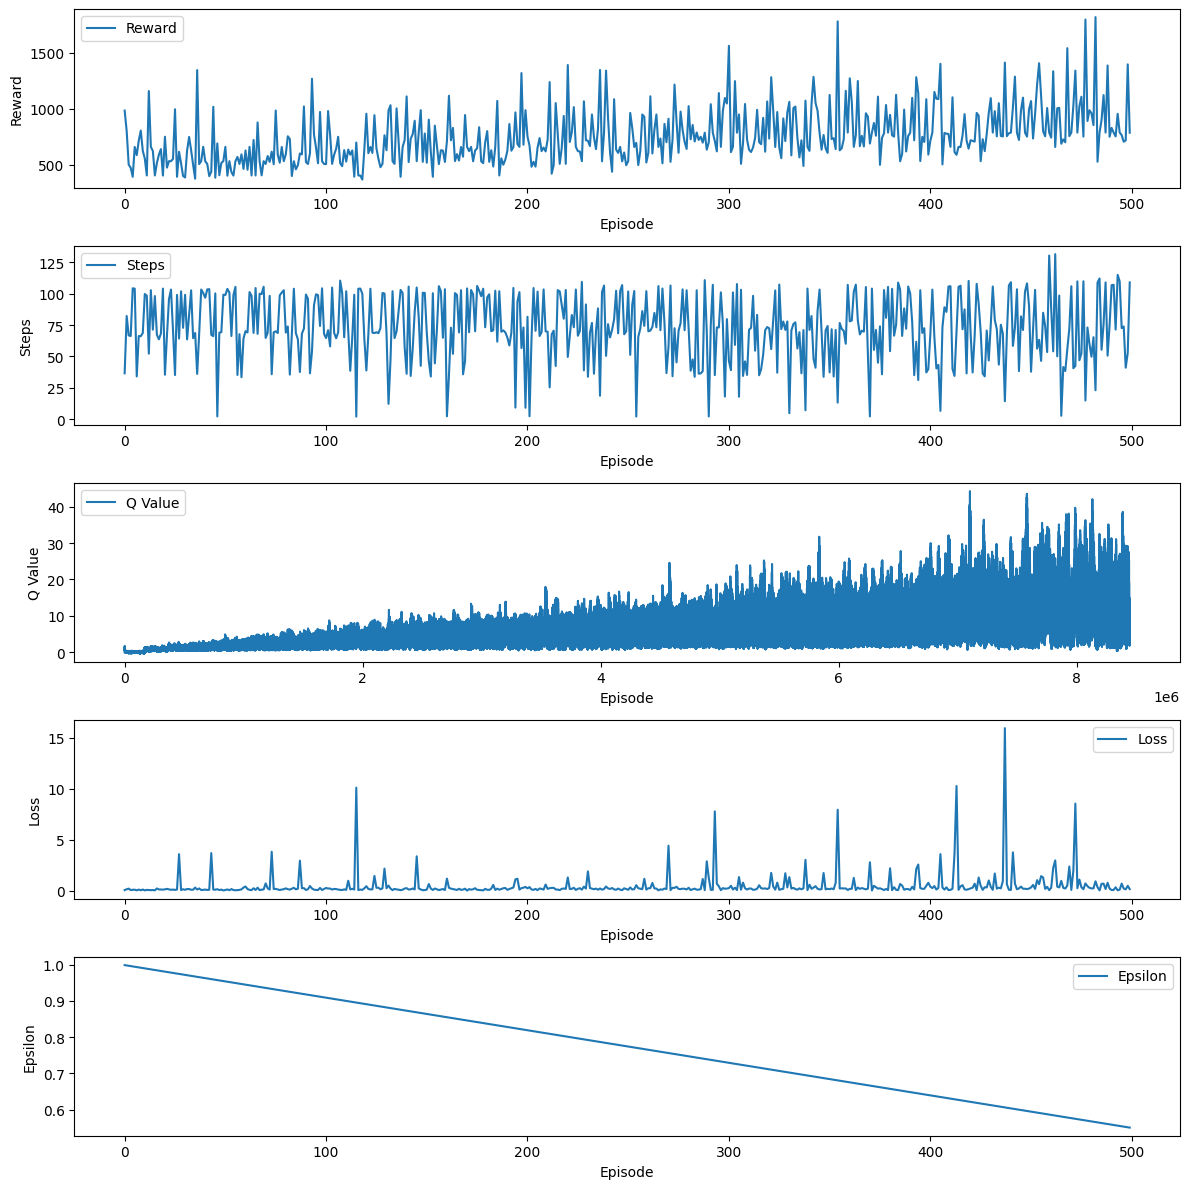

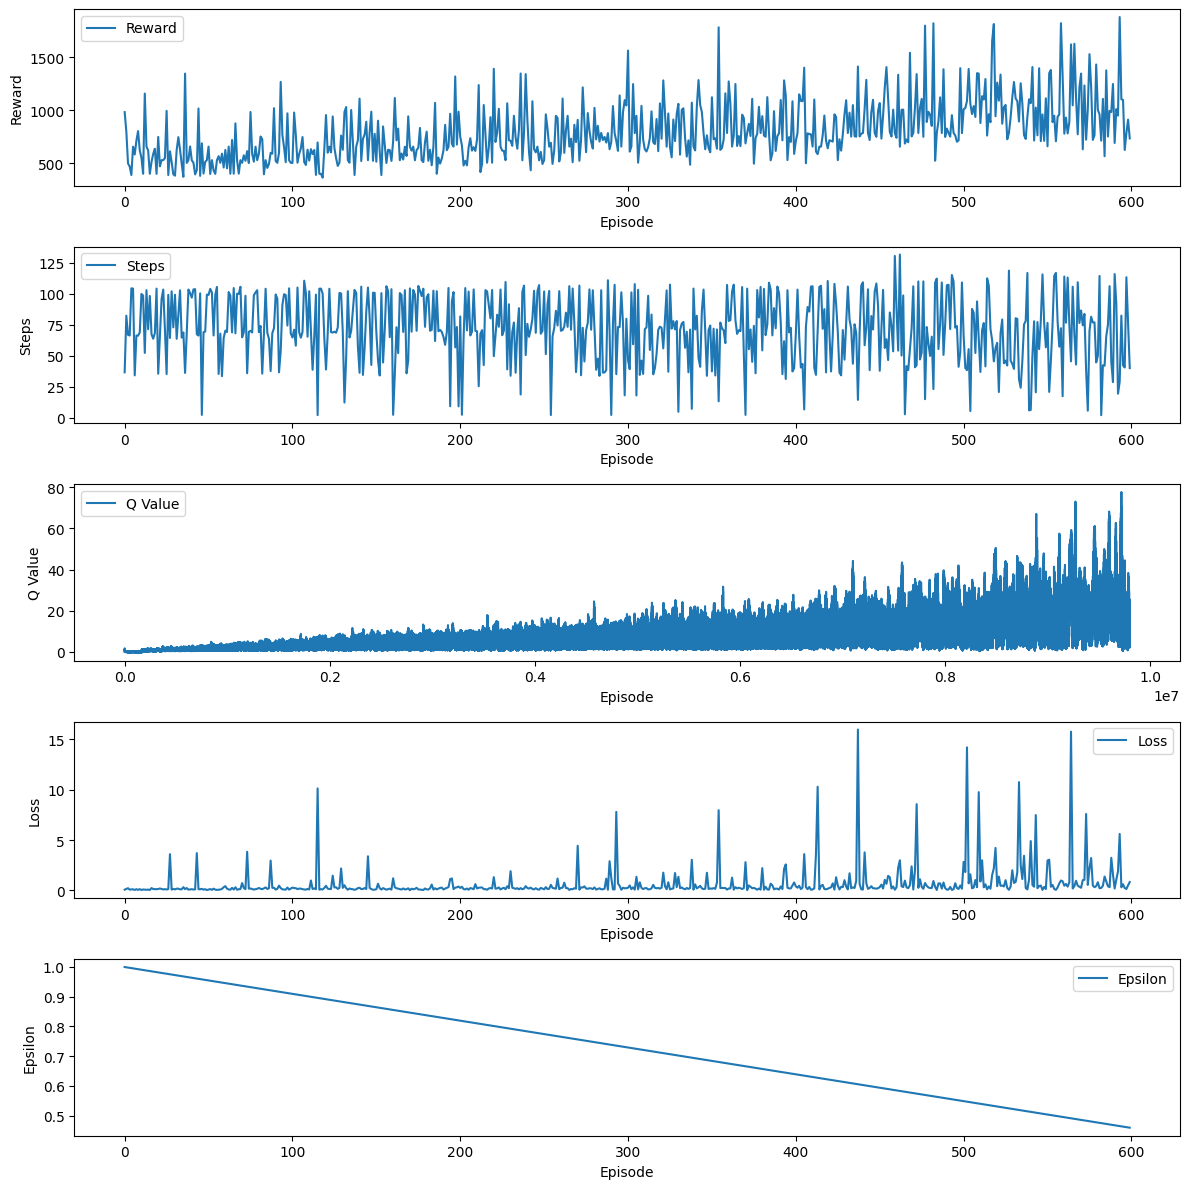

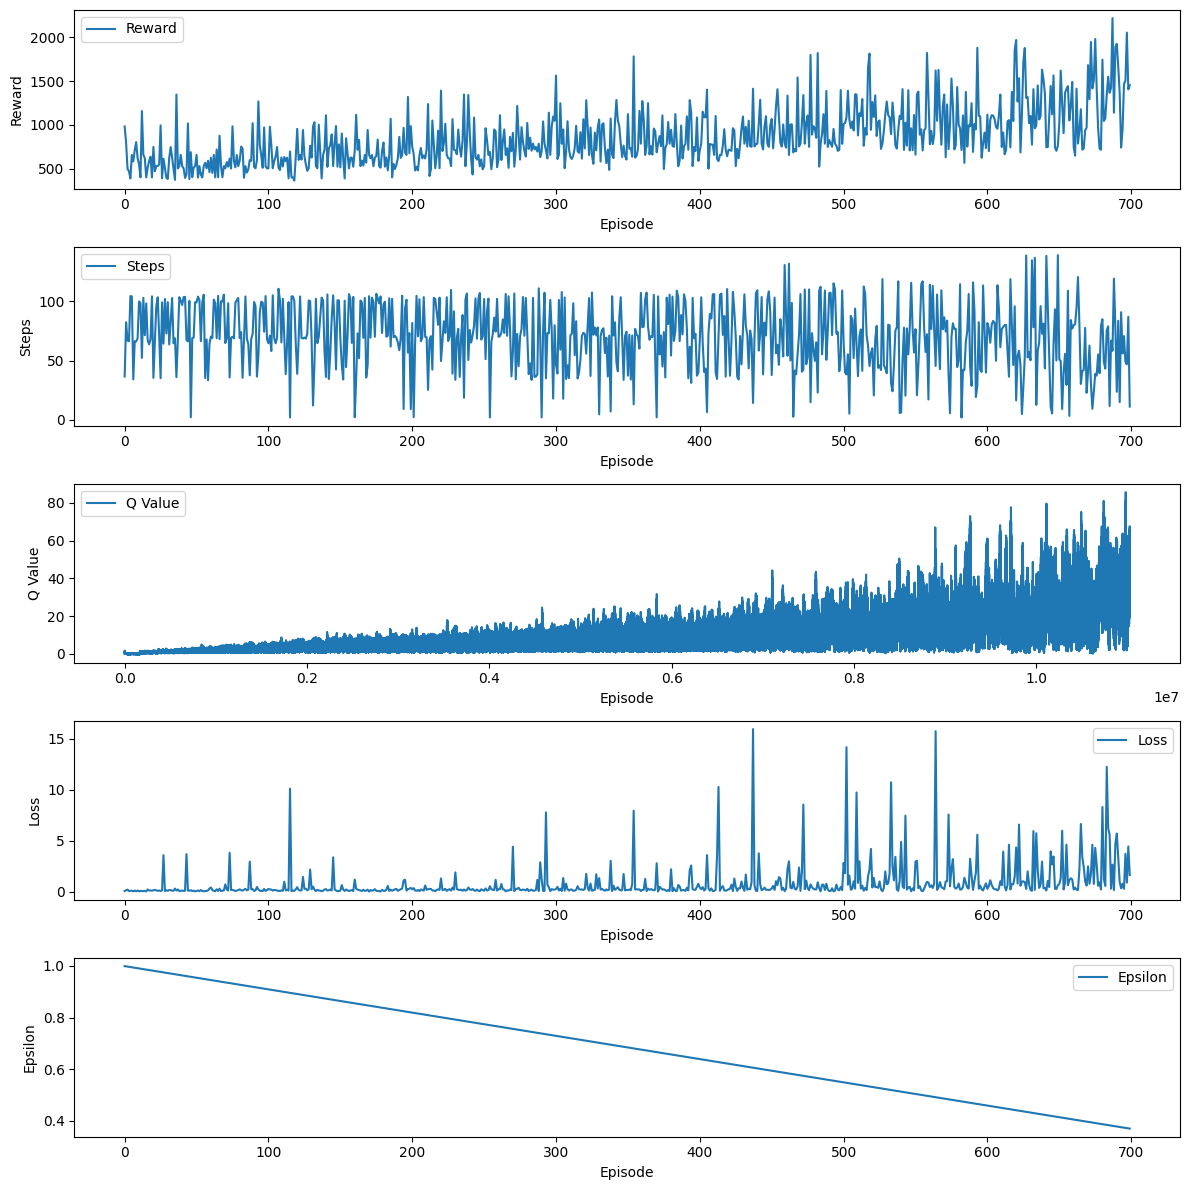

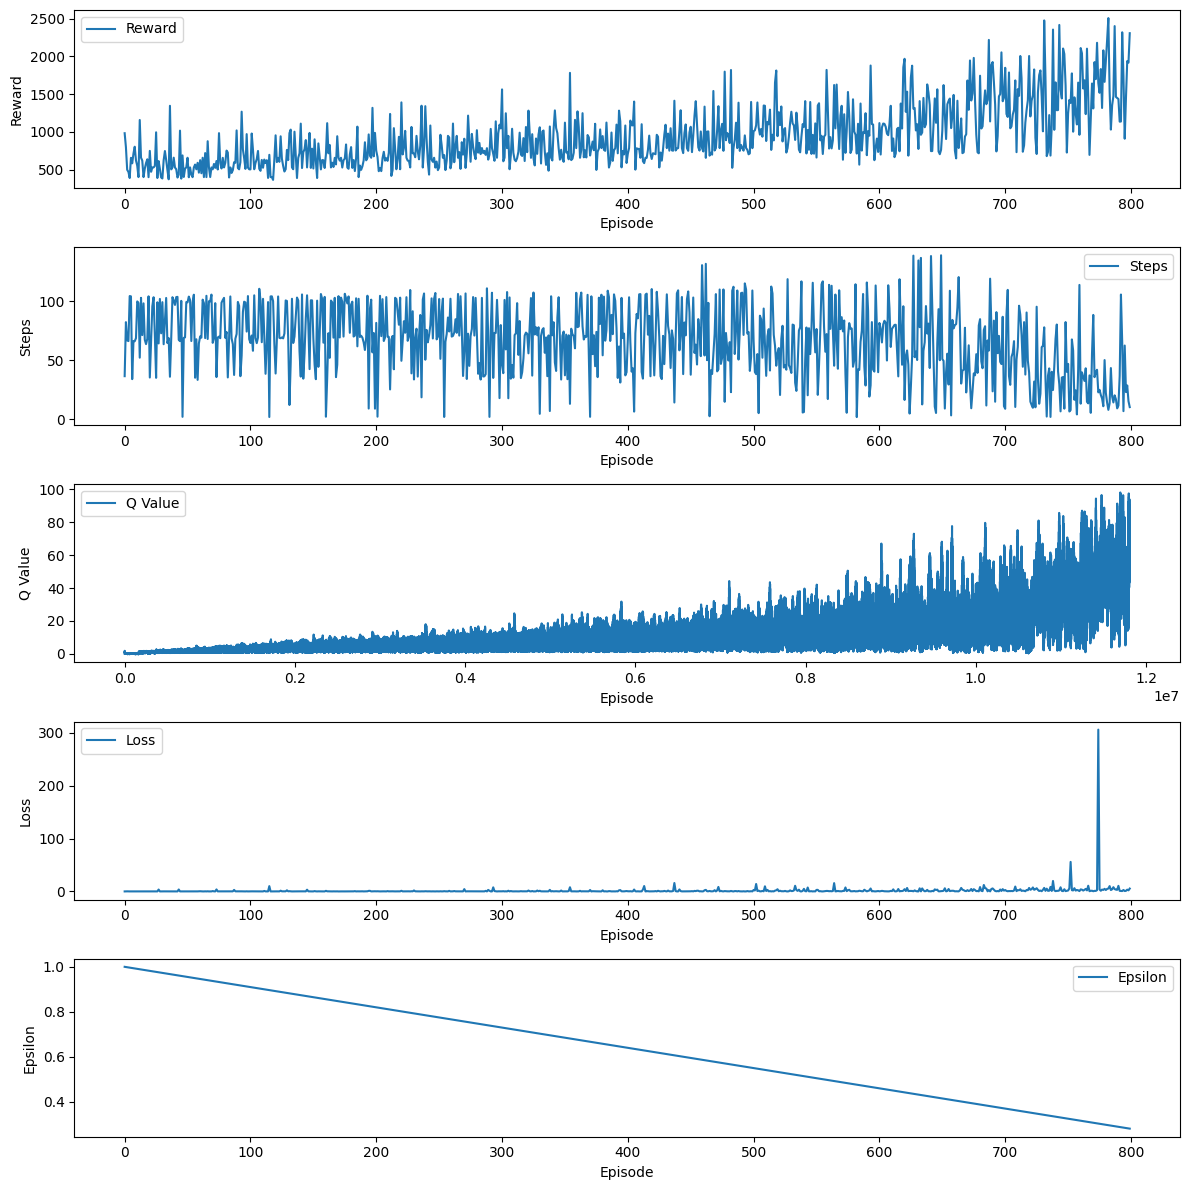

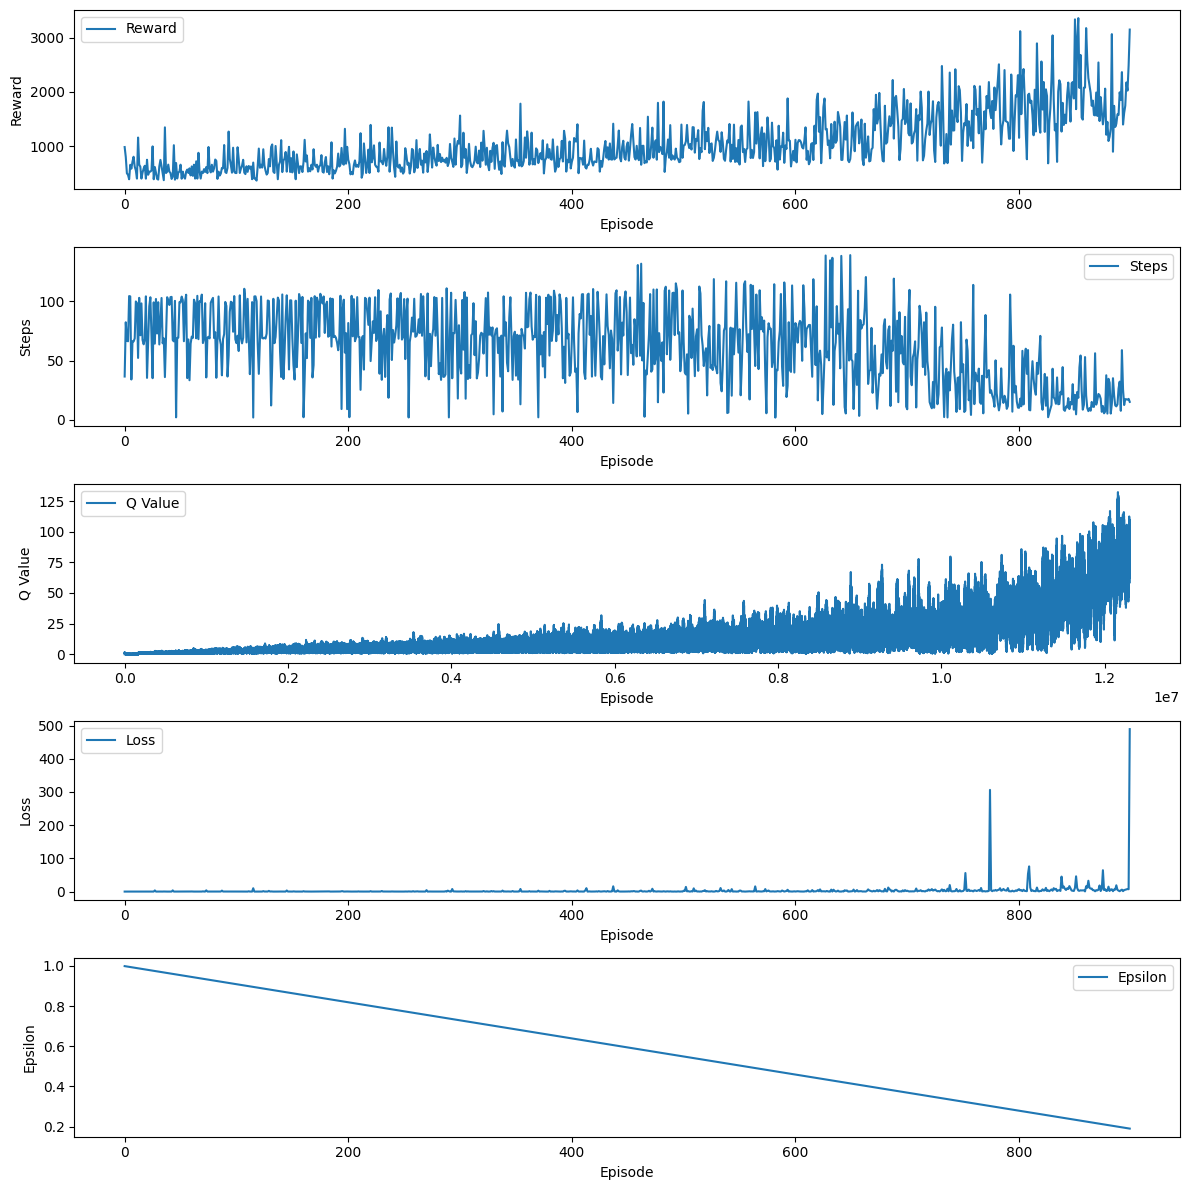

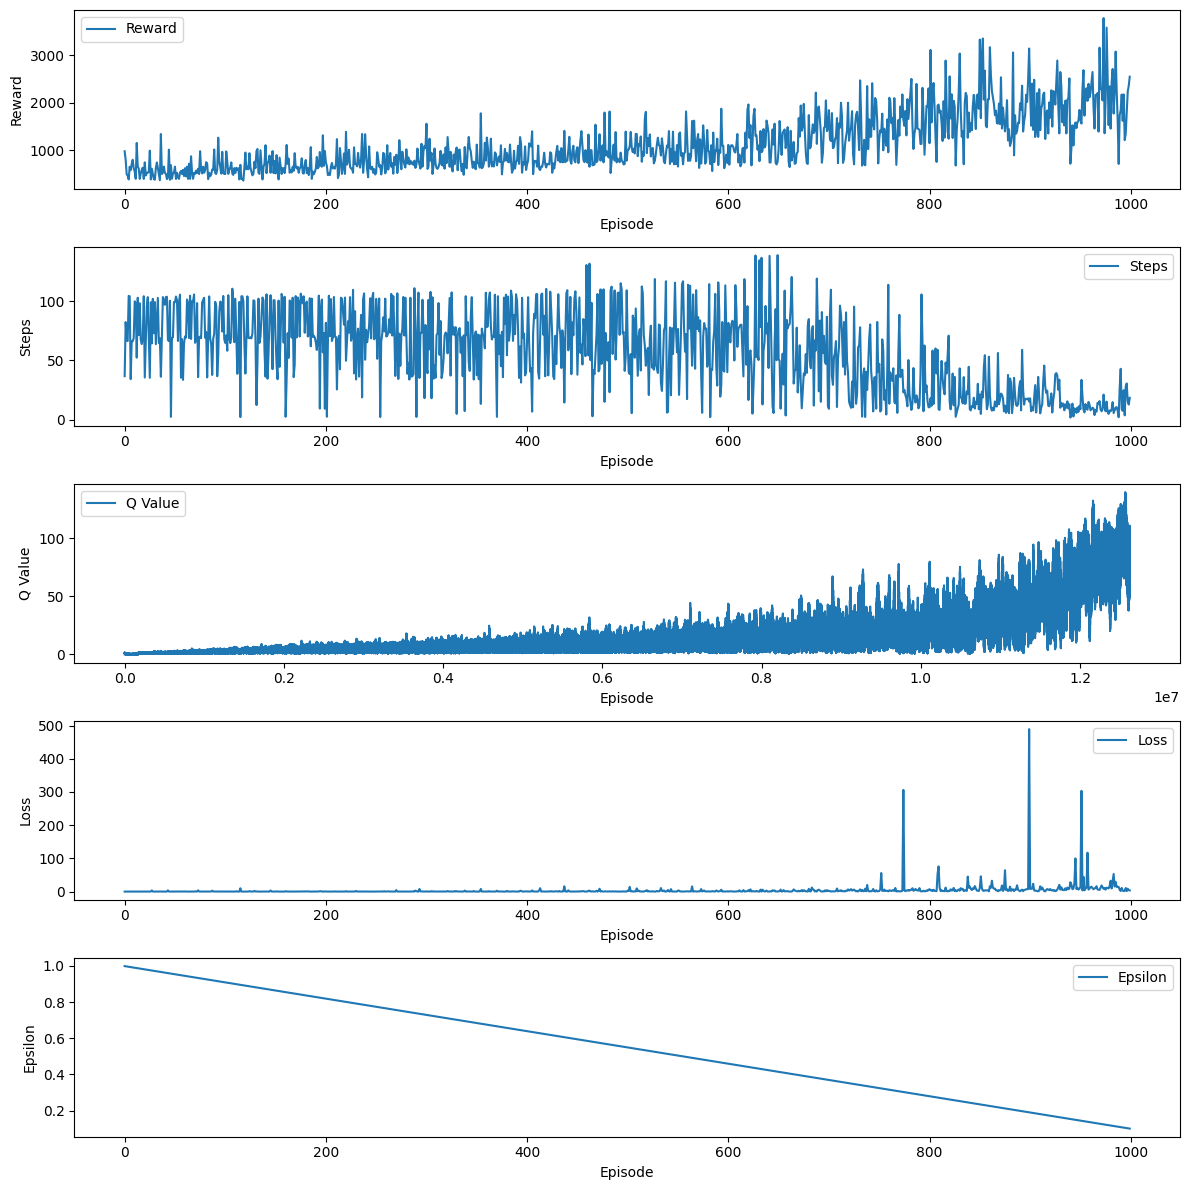

In [8]:
epsilon = EPSILON_START
episode_rewards = list()
episode_durations = list()
episode_steps = list()
q_values = list()
losses = list()
epsilons = list()

for episode in tqdm(range(1, N_EPISODES + 1), total=N_EPISODES, desc="Training"):
    frame_stack = collections.deque(maxlen=N_STACKD_FRAMES)
    start = time.time()
    state = env.reset()
    state = preprocess_state(
        state, frame_stack=frame_stack, stack_size=N_STACKD_FRAMES
    ).to(device)

    done = False
    total_reward = 0
    total_steps = 0
    while not done or info["flag_get"]:

        if np.random.rand() <= epsilon:
            action = np.random.randint(env.action_space.n)
        else:
            action = dqn(state).argmax().item()

        next_state, reward, done, info = env.step(action)
        next_state = preprocess_state(
            next_state, frame_stack=frame_stack, stack_size=N_STACKD_FRAMES
        ).to(device)

        total_reward += reward

        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

        if len(replay_buffer.buffer) > BATCH_SIZE:
            exp = replay_buffer.sample(BATCH_SIZE)
            (
                sample_states,
                sample_actions,
                sample_rewards,
                sample_next_states,
                sample_dones,
            ) = zip(*exp)

            sample_states = torch.cat(sample_states).to(device)
            sample_actions = torch.LongTensor(sample_actions).to(device)
            sample_rewards = torch.FloatTensor(sample_rewards).to(device)
            sample_next_states = torch.cat(sample_next_states).to(device)
            sample_dones = torch.FloatTensor(sample_dones).to(device)

            q_curr_state = (
                dqn(sample_states).gather(1, sample_actions.unsqueeze(-1)).squeeze(-1)
            )
            q_next_state = target_net(sample_next_states).max(dim=1)[0]
            expected_q = sample_rewards + GAMMA * q_next_state * (1 - sample_dones)

            loss = nn.MSELoss()(q_curr_state, expected_q)
            optimizer.zero_grad()
            loss.backward()
            # clip gradients to stabilize training
            nn.utils.clip_grad_norm_(dqn.parameters(), 1)
            optimizer.step()
            q_values.append(q_curr_state.mean().item())

        total_steps += 1

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(dqn.state_dict())

    # update epsilion
    # uncomment the following line to use exponential decay
    # epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    # uncomment the following line to use linear decay
    epsilon = max(EPSILON_END, epsilon - EPSILON_DECAY)

    # save metrics
    episode_rewards.append(total_reward)
    episode_durations.append(time.time() - start)
    episode_steps.append(total_steps)
    losses.append(loss.item())
    epsilons.append(epsilon)

    if episode % 100 == 0:
        plot_results(
            reward_list=episode_rewards,
            steps_list=episode_durations,
            q_list=q_values,
            loss_list=losses,
            epsilon_list=epsilons,
            save_fig=True,
            save_path=os.path.join(plot_folder, f"results_{episode}"),
        )

    if episode % CHECKPOINT_RATE == 0:
        checkpoint_path = os.path.join(checkpoint_folder, f"checkpoint_{episode}.pth")
        torch.save(
            {
                "episode": episode,
                "model_state_dict": dqn.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss,
                "epsilon": epsilon,
            },
            checkpoint_path,
        )

env.close()
torch.save(dqn.state_dict(), os.path.join(model_folder, f"{agent}.pth"))

## Evaluate Agent


In [9]:
eval_env = gym_super_mario_bros.make("SuperMarioBros-v0")
eval_env = JoypadSpace(eval_env, SIMPLE_MOVEMENT)
eval_env = gym.wrappers.Monitor(
    eval_env, videos_folder, video_callable=lambda episode_id: True, force=True
)

# uncomment the following lines to load the model from saved checkpoint
dqn = DQN(INPUT_SHAPE, eval_env.action_space.n).to(device)
dqn.load_state_dict(torch.load(os.path.join(model_folder, "dqn.pth")))
dqn.eval()

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=7, bias=True)
  )
)

In [10]:
reward_list = list()
steps_list = list()

for episode in tqdm(range(1, 11), total=10, desc="Evaluation"):
    frame_stack = collections.deque(maxlen=N_STACKD_FRAMES)
    start = time.time()
    state = eval_env.reset()
    state = preprocess_state(
        state, frame_stack=frame_stack, stack_size=N_STACKD_FRAMES
    ).to(device)

    done = False
    total_reward = 0
    total_steps = 0
    while not done:
        action = dqn(state).argmax().item()
        next_state, reward, done, info = eval_env.step(action)
        done = done or info["flag_get"]

        next_state = preprocess_state(
            next_state, frame_stack=frame_stack, stack_size=N_STACKD_FRAMES
        ).to(device)

        total_reward += reward
        total_steps += 1
        state = next_state

    reward_list.append(total_reward)
    steps_list.append(total_steps)

eval_env.close()

Evaluation: 100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


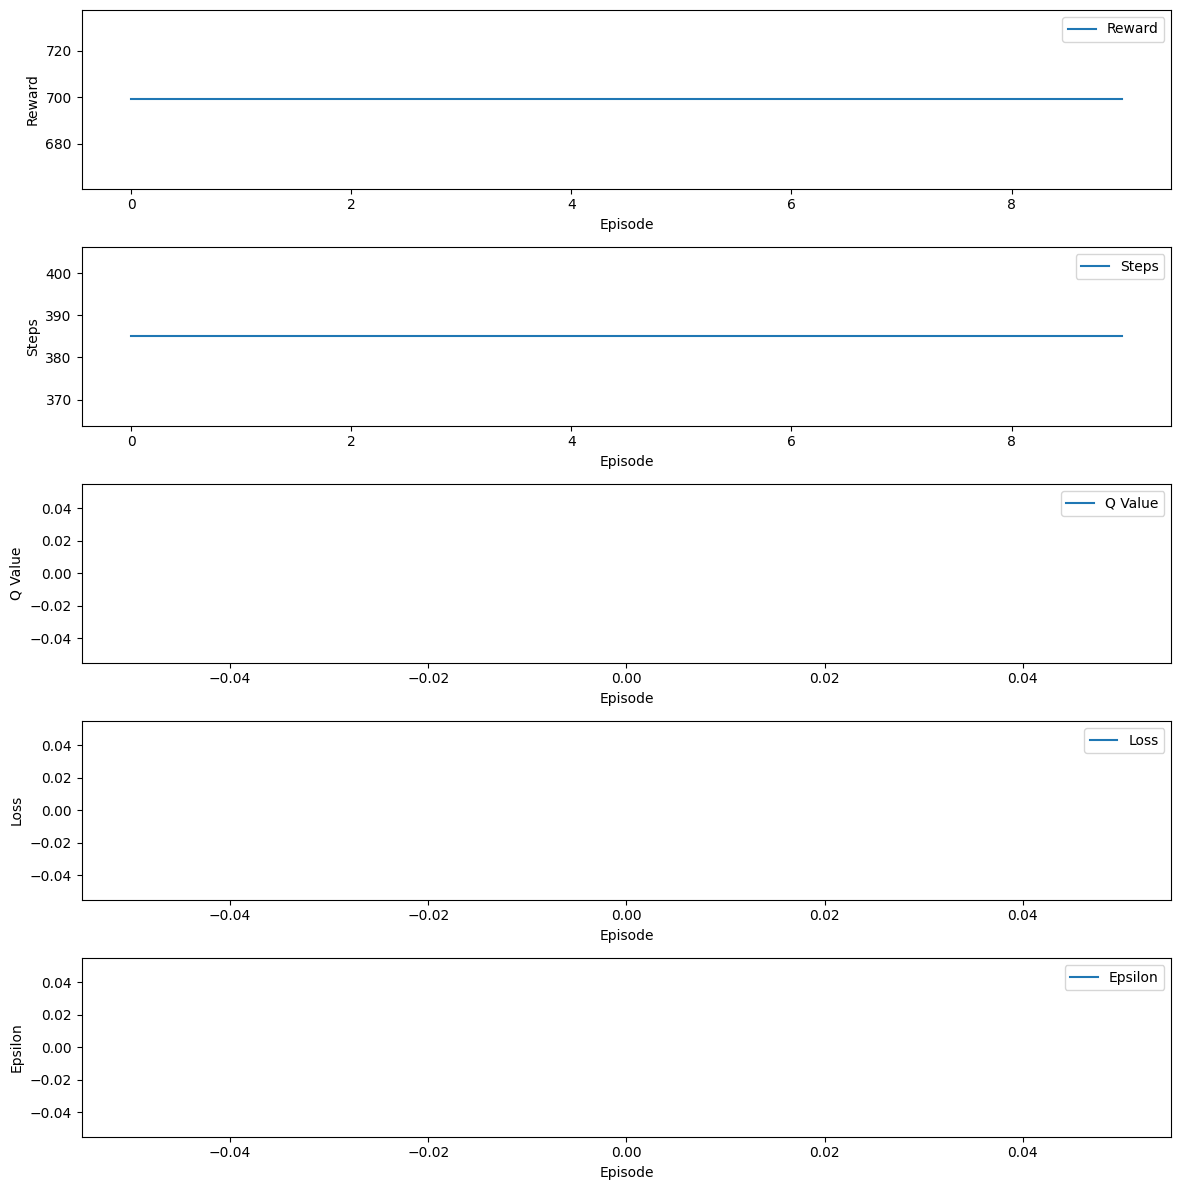

In [11]:
plot_results(
    reward_list=reward_list,
    steps_list=steps_list,
    q_list=[],
    loss_list=[],
    epsilon_list=[],
    save_fig=True,
    save_path=os.path.join(plot_folder, f"evaluation.png"),
)